In [90]:
import os, json, pathlib, importlib
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, brier_score_loss, log_loss,
    roc_curve, precision_recall_curve, auc as auc_fn,
    confusion_matrix
)

# project helpers
import sys
sys.path.append(os.path.abspath(".."))
from src import data as data_mod, features as features_mod, utils as utils_mod
importlib.reload(data_mod); importlib.reload(features_mod); importlib.reload(utils_mod)
from src.data import get_data
from src.features import add_features
from src.utils import make_labels

# optional XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["axes.grid"] = True
os.makedirs("data", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)
os.makedirs("reports/figures", exist_ok=True)


In [91]:
TICKER   = "AAPL"
START, END = "2015-01-01", "2023-12-31"
TAU, DEAD_ZONE = 0.001, True   # ±0.1% dead-zone

df = get_data(TICKER, start=START, end=END)
df = add_features(df)
df = make_labels(df, tau=TAU, dead_zone=DEAD_ZONE)

feat_cols = [c for c in df.columns if c not in ["date","open","high","low","close","volume","ret_next","y"]]
X = df[feat_cols].values
y = df["y"].astype(int).values

n = len(df)
i_tr, i_va, i_te = int(0.70*n), int(0.85*n), n
X_tr, y_tr = X[:i_tr], y[:i_tr]
X_va, y_va = X[i_tr:i_va], y[i_tr:i_va]
X_te, y_te = X[i_va:], y[i_va:]

scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr); X_va = scaler.transform(X_va); X_te = scaler.transform(X_te)

len(df), len(feat_cols)


(2078, 8)

In [92]:
# Logistic Regression
lr = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=None)
lr.fit(X_tr, y_tr)
p_va_lr = lr.predict_proba(X_va)[:,1]
p_te_lr = lr.predict_proba(X_te)[:,1]

# XGB (optional)
if HAS_XGB:
    xgb = XGBClassifier(
        n_estimators=400, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        random_state=42, n_jobs=-1
    )
    xgb.fit(X_tr, y_tr)
    p_va_xgb = xgb.predict_proba(X_va)[:,1]
    p_te_xgb = xgb.predict_proba(X_te)[:,1]
else:
    p_va_xgb = p_te_xgb = None

print("AUC (VAL) — LR:",  roc_auc_score(y_va, p_va_lr))
print("AUC (TEST) — LR:", roc_auc_score(y_te, p_te_lr))
if HAS_XGB:
    print("AUC (VAL) — XGB:",  roc_auc_score(y_va, p_va_xgb))
    print("AUC (TEST) — XGB:", roc_auc_score(y_te, p_te_xgb))


AUC (VAL) — LR: 0.48589780541030186
AUC (TEST) — LR: 0.474127606855255
AUC (VAL) — XGB: 0.5453534812862849
AUC (TEST) — XGB: 0.4545942597563494


In [93]:
def pr_auc(y_true, p_pred):
    pr, rc, _ = precision_recall_curve(y_true, p_pred)
    return float(auc_fn(rc, pr))

rows = []
rows += [dict(model="LR", split="val",
              AUC=roc_auc_score(y_va,p_va_lr), PR_AUC=pr_auc(y_va,p_va_lr),
              Brier=brier_score_loss(y_va,p_va_lr), LogLoss=log_loss(y_va,p_va_lr),
              PosRate=float(y_va.mean()))]
rows += [dict(model="LR", split="test",
              AUC=roc_auc_score(y_te,p_te_lr), PR_AUC=pr_auc(y_te,p_te_lr),
              Brier=brier_score_loss(y_te,p_te_lr), LogLoss=log_loss(y_te,p_te_lr),
              PosRate=float(y_te.mean()))]

if HAS_XGB and p_va_xgb is not None:
    rows += [dict(model="XGB", split="val",
                  AUC=roc_auc_score(y_va,p_va_xgb), PR_AUC=pr_auc(y_va,p_va_xgb),
                  Brier=brier_score_loss(y_va,p_va_xgb), LogLoss=log_loss(y_va,p_va_xgb),
                  PosRate=float(y_va.mean()))]
    rows += [dict(model="XGB", split="test",
                  AUC=roc_auc_score(y_te,p_te_xgb), PR_AUC=pr_auc(y_te,p_te_xgb),
                  Brier=brier_score_loss(y_te,p_te_xgb), LogLoss=log_loss(y_te,p_te_xgb),
                  PosRate=float(y_te.mean()))]

metrics_df = pd.DataFrame(rows)
display(metrics_df)

summary = metrics_df.query("split=='test'")[["model","AUC","Brier"]].copy()
summary["model"] = summary["model"].str.lower()
summary.to_csv("data/explainability_summary.csv", index=False)
print("Wrote data/explainability_summary.csv")


,model,split,AUC,PR_AUC,Brier,LogLoss,PosRate
0,LR,val,0.485898,0.506002,0.251636,0.696429,0.522436
1,LR,test,0.474128,0.520769,0.253512,0.700284,0.535256
2,XGB,val,0.545353,0.552420,0.264401,0.729758,0.522436
3,XGB,test,0.454594,0.494302,0.295353,0.799396,0.535256


Wrote data/explainability_summary.csv


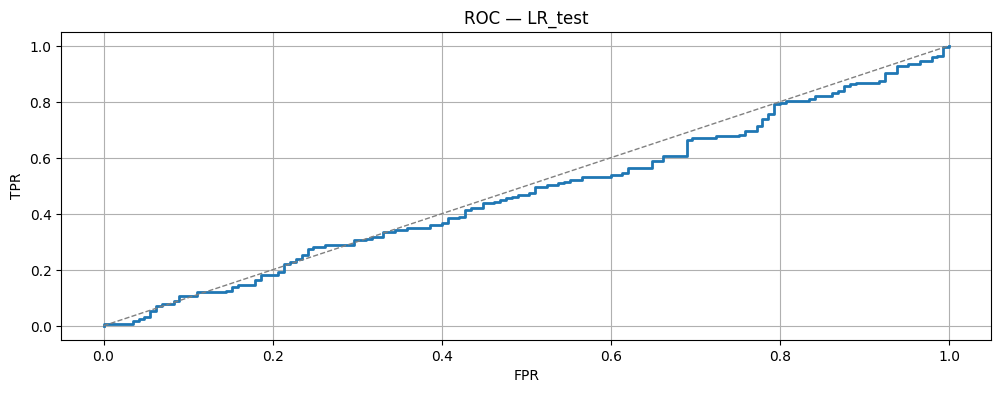

saved reports/figures/roc_lr_test.png


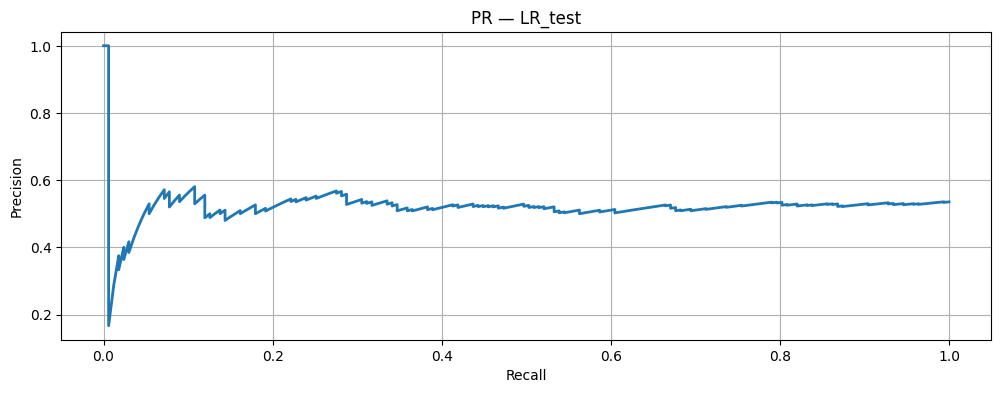

saved reports/figures/pr_lr_test.png


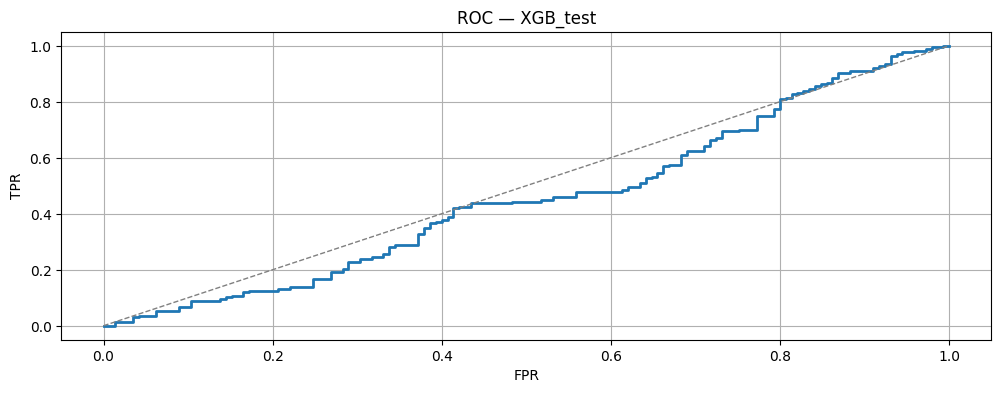

saved reports/figures/roc_xgb_test.png


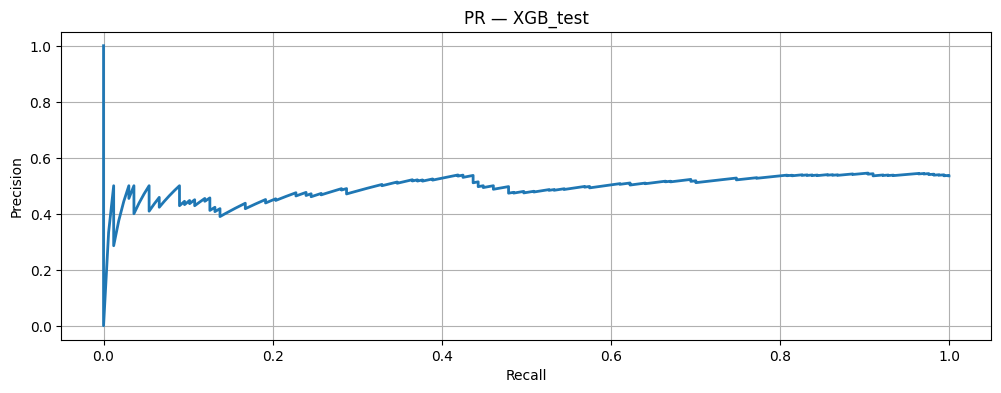

saved reports/figures/pr_xgb_test.png


In [94]:
def plot_and_save_roc(y_true, p_pred, label):
    fpr, tpr, _ = roc_curve(y_true, p_pred)
    plt.figure(figsize=(12,4))
    plt.plot(fpr, tpr, lw=2)
    plt.plot([0,1],[0,1],"--", color="gray", lw=1)
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — {label}")
    out = f"reports/figures/roc_{label.replace(' ','_').lower()}.png"
    plt.savefig(out, dpi=150, bbox_inches="tight"); plt.show()
    print("saved", out)

def plot_and_save_pr(y_true, p_pred, label):
    pr, rc, _ = precision_recall_curve(y_true, p_pred)
    plt.figure(figsize=(12,4))
    plt.plot(rc, pr, lw=2)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR — {label}")
    out = f"reports/figures/pr_{label.replace(' ','_').lower()}.png"
    plt.savefig(out, dpi=150, bbox_inches="tight"); plt.show()
    print("saved", out)

plot_and_save_roc(y_te, p_te_lr,  "LR_test")
plot_and_save_pr (y_te, p_te_lr,  "LR_test")
if HAS_XGB and p_te_xgb is not None:
    plot_and_save_roc(y_te, p_te_xgb, "XGB_test")
    plot_and_save_pr (y_te, p_te_xgb, "XGB_test")


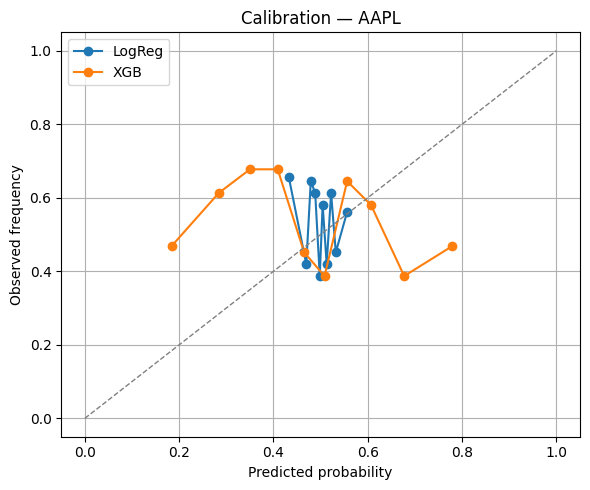

Brier (LR):  0.253512
Brier (XGB): 0.295353


In [95]:
from sklearn.calibration import calibration_curve

def plot_calibration(y_true, p_pred, label, n_bins=10):
    frac_pos, mean_pred = calibration_curve(y_true, p_pred, n_bins=n_bins, strategy="quantile")
    plt.plot(mean_pred, frac_pos, marker="o", label=label)

plt.figure(figsize=(6,5))
plot_calibration(y_te, p_te_lr, "LogReg")
if HAS_XGB and p_te_xgb is not None:
    plot_calibration(y_te, p_te_xgb, "XGB")
plt.plot([0,1],[0,1],"--", color="gray", lw=1)
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title(f"Calibration — {TICKER}"); plt.legend(); plt.tight_layout()
plt.show()

print("Brier (LR): ", round(brier_score_loss(y_te, p_te_lr), 6))
if HAS_XGB and p_te_xgb is not None:
    print("Brier (XGB):", round(brier_score_loss(y_te, p_te_xgb), 6))


In [96]:
def pick_threshold_max_f1(y_true, p_pred):
    pr, rc, thr = precision_recall_curve(y_true, p_pred)
    f1 = (2*pr*rc)/(pr+rc+1e-12)
    i = np.nanargmax(f1)
    # precision_recall_curve returns thresholds for all but first point
    t = thr[max(i-1, 0)] if len(thr) else 0.5
    return float(t), float(f1[i])

t_star, f1_star = pick_threshold_max_f1(y_va, p_va_lr)
print(f"LR threshold* (val max-F1): {t_star:.3f} (F1={f1_star:.3f})")

yhat_te = (p_te_lr >= t_star).astype(int)
cm = pd.DataFrame(confusion_matrix(y_te, yhat_te),
                  index=pd.Index([0,1], name="Actual"),
                  columns=pd.Index([0,1], name="Pred"))
display(cm)

# save artifacts
import joblib
joblib.dump(scaler, "artifacts/scaler.joblib")
joblib.dump(lr,     "artifacts/lr.joblib")
json.dump({"threshold": t_star}, open("artifacts/threshold.json","w"))
json.dump({"features": feat_cols}, open("artifacts/feature_list.json","w"))
print("Saved scaler, lr, threshold, feature_list → artifacts/")


LR threshold* (val max-F1): 0.415 (F1=0.694)


Pred,0,1
Actual,,
0,2,143
1,6,161


Saved scaler, lr, threshold, feature_list → artifacts/


In [97]:
df_te = df.iloc[i_va:].copy()
df_te["p_lr"] = p_te_lr
df_te["year"] = pd.to_datetime(df_te["date"]).dt.year

def _row_metrics(g):
    auc = roc_auc_score(g["y"], g["p_lr"]) if g["y"].nunique() > 1 else np.nan
    return pd.Series({
        "AUC": auc,
        "Brier": brier_score_loss(g["y"], g["p_lr"]),
        "PosRate": float(g["y"].mean()),
    })

by_year = df_te.groupby("year", group_keys=False).apply(_row_metrics)
display(by_year)
by_year.to_csv("data/metrics_by_year_LR.csv")
print("Wrote data/metrics_by_year_LR.csv")


C:\Users\byu30\AppData\Local\Temp\ipykernel_22352\2044862141.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_year = df_te.groupby("year", group_keys=False).apply(_row_metrics)


,AUC,Brier,PosRate
year,,,
2022,0.424517,0.258608,0.439024
2023,0.474979,0.251695,0.569565


Wrote data/metrics_by_year_LR.csv


In [98]:
coefs = pd.Series(lr.coef_.ravel(), index=feat_cols)
imp = (pd.DataFrame({"feature": coefs.index, "coef": coefs.values})
         .assign(abs_coef=lambda d: d["coef"].abs())
         .sort_values("abs_coef", ascending=False))
display(imp)
imp.to_csv("data/lr_feature_importance.csv", index=False)


,feature,coef,abs_coef
0,ret1,-0.172956,0.172956
1,ret5,0.045659,0.045659
2,ret10,0.041445,0.041445
7,macd_signal,0.037420,0.037420
6,macd,-0.036132,0.036132
5,rsi14,0.019277,0.019277
4,volz,0.015563,0.015563
3,vol10,-0.010030,0.010030


In [99]:
def sweep_tau_deadzone(taus=(0.001,0.002,0.003,0.004), dead_flags=(True, False)):
    out = []
    for tau in taus:
        for dz in dead_flags:
            d = make_labels(add_features(get_data(TICKER, start=START, end=END)),
                            tau=tau, dead_zone=dz)
            Xs = d[feat_cols].values
            ys = d["y"].astype(int).values
            n = len(d)
            i_tr, i_va, i_te = int(0.70*n), int(0.85*n), n
            Xtr, Xva, Xte = Xs[:i_tr], Xs[i_tr:i_va], Xs[i_va:]
            ytr, yva, yte = ys[:i_tr], ys[i_tr:i_va], ys[i_va:]
            sc = StandardScaler().fit(Xtr)
            Xtr, Xva, Xte = sc.transform(Xtr), sc.transform(Xva), sc.transform(Xte)
            m = LogisticRegression(max_iter=2000, class_weight="balanced").fit(Xtr, ytr)
            pva = m.predict_proba(Xva)[:,1]; pte = m.predict_proba(Xte)[:,1]
            def prauc(y,p):
                pr, rc, _ = precision_recall_curve(y,p); return float(auc_fn(rc,pr))
            out.append(dict(
                tau=tau, dead_zone=dz,
                pos_rate_val=float(yva.mean()), pos_rate_test=float(yte.mean()),
                AUC_val=roc_auc_score(yva,pva), PR_val=prauc(yva,pva),
                Brier_val=brier_score_loss(yva,pva), LogLoss_val=log_loss(yva,pva),
                AUC_test=roc_auc_score(yte,pte), PR_test=prauc(yte,pte),
                Brier_test=brier_score_loss(yte,pte), LogLoss_test=log_loss(yte,pte),
            ))
    return pd.DataFrame(out)

robust = sweep_tau_deadzone()
display(robust.sort_values(["AUC_test"], ascending=False))
robust.to_csv("data/labeling_robustness_lr.csv", index=False)
print("Wrote data/labeling_robustness_lr.csv")


,tau,dead_zone,pos_rate_val,pos_rate_test,AUC_val,PR_val,Brier_val,LogLoss_val,AUC_test,PR_test,Brier_test,LogLoss_test
3,0.002,False,0.458084,0.477612,0.503774,0.453013,0.251141,0.695454,0.500071,0.477847,0.251956,0.697121
5,0.003,False,0.437126,0.438806,0.479853,0.419188,0.253150,0.699501,0.486865,0.434469,0.252303,0.697808
4,0.003,True,0.539033,0.529630,0.493215,0.528317,0.252003,0.697179,0.477176,0.519672,0.253346,0.699997
0,0.001,True,0.522436,0.535256,0.485898,0.506002,0.251636,0.696429,0.474128,0.520769,0.253512,0.700284
1,0.001,False,0.494012,0.501493,0.481980,0.479188,0.251713,0.696585,0.471664,0.490374,0.252936,0.699078
6,0.004,True,0.533865,0.519841,0.476272,0.516777,0.252915,0.699011,0.467415,0.508593,0.253687,0.700678
7,0.004,False,0.407186,0.402985,0.463495,0.376289,0.256993,0.707347,0.465667,0.391793,0.255110,0.703495
2,0.002,True,0.524138,0.532646,0.501812,0.529910,0.250568,0.694277,0.461433,0.506820,0.253806,0.700878


Wrote data/labeling_robustness_lr.csv


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


CAGR           0.173410
Vol            0.270308
Sharpe         0.641528
MaxDD         -0.235842
HitRate        0.516026
TurnoverYr    11.307692
dtype: float64

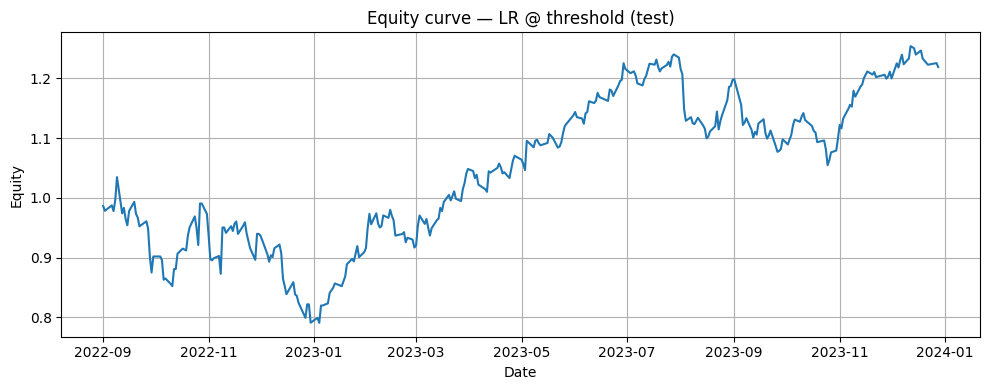

In [ ]:
# use next-day returns 'ret_next' in df_te (already aligned by your utils)
df_te_bt = df.iloc[i_va:].copy()
df_te_bt["p"] = p_te_lr
df_te_bt["signal"] = (df_te_bt["p"] >= t_star).astype(int)  # long or flat
# equity with 1-day hold; no costs
df_te_bt["strategy_ret"] = df_te_bt["signal"] * df_te_bt["ret_next"]
df_te_bt["equity"] = (1.0 + df_te_bt["strategy_ret"]).cumprod()

def summarize_equity(e):
    rets = e["strategy_ret"].values
    cagr = e["equity"].iloc[-1]**(252/len(e)) - 1
    vol  = np.std(rets)*np.sqrt(252)
    sharpe = cagr/vol if vol>0 else np.nan
    dd = (e["equity"]/e["equity"].cummax() - 1).min()
    hit = (rets>0).mean()
    turn_yr = df_te_bt["signal"].diff().abs().sum()/len(e)*252
    return pd.Series(dict(CAGR=cagr, Vol=vol, Sharpe=sharpe, MaxDD=dd, HitRate=hit, TurnoverYr=turn_yr))

summary_bt = summarize_equity(df_te_bt)
display(summary_bt)

plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(df_te_bt["date"]), df_te_bt["equity"])
plt.title("Equity curve — LR @ threshold (test)")
plt.xlabel("Date"); plt.ylabel("Equity"); plt.tight_layout()
plt.savefig("reports/figures/equity_curve_lr.png", dpi=150, bbox_inches="tight"); plt.show()


In [105]:
from datetime import datetime
import json, pathlib
import pandas as pd

# --- tiny helper to render a DataFrame as Markdown (no tabulate needed) ---
def df_to_md(df: pd.DataFrame, index=False, floatfmt=".4f") -> str:
    df2 = df.copy()
    # format numeric columns
    for col in df2.select_dtypes(include="number").columns:
        df2[col] = df2[col].map(lambda x: f"{x:{floatfmt}}" if pd.notnull(x) else "")
    # header
    cols = (["index"] + df2.columns.tolist()) if index else df2.columns.tolist()
    lines = [
        "|" + "|".join(map(str, cols)) + "|",
        "|" + "|".join(["---"] * len(cols)) + "|",
    ]
    # rows
    for idx, s in df2.iterrows():
        cells = [str(idx)] + [str(v) for v in s.values] if index else [str(v) for v in s.values]
        lines.append("|" + "|".join(cells) + "|")
    return "\n".join(lines)

# expects these to already exist from earlier cells:
# TICKER, START, END, TAU, DEAD_ZONE, feat_cols, t_star

card_tbl = pd.read_csv("data/explainability_summary.csv")
by_year_tbl = pd.read_csv("data/metrics_by_year_LR.csv", index_col=0)

card_md = f"""# Model Card — Stock Direction (LogReg)
**Date:** {datetime.utcnow().strftime('%Y-%m-%d')}
**Ticker:** {TICKER} | **Period:** {START} → {END}
**Labeling:** tau={TAU}, dead_zone={DEAD_ZONE}
**Features ({len(feat_cols)}):** {', '.join(feat_cols[:12])}{' ...' if len(feat_cols)>12 else ''}

## Metrics
{df_to_md(card_tbl, index=False)}

**Val-chosen threshold (max-F1):** {t_star:.3f}

## Stability (test by year)
{df_to_md(by_year_tbl, index=True)}

## Artifacts
- `artifacts/scaler.joblib`, `artifacts/lr.joblib`, `artifacts/threshold.json`, `artifacts/feature_list.json`
- Curves: `reports/figures/roc_*.png`, `pr_*.png`, `equity_curve_lr.png`
"""

pathlib.Path("reports").mkdir(parents=True, exist_ok=True)
pathlib.Path("reports/model_card.md").write_text(card_md, encoding="utf-8")
print("Wrote reports/model_card.md")

Wrote reports/model_card.md


C:\Users\byu30\AppData\Local\Temp\ipykernel_22352\3665810594.py:30: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  **Date:** {datetime.utcnow().strftime('%Y-%m-%d')}


In [106]:
print("AUC_test (LR):", round(metrics_df.query("model=='LR' & split=='test'")["AUC"].iloc[0], 4))
if HAS_XGB:
    print("AUC_test (XGB):", round(metrics_df.query("model=='XGB' & split=='test'")["AUC"].iloc[0], 4))
print("Brier_test (LR):", round(metrics_df.query("model=='LR' & split=='test'")["Brier"].iloc[0], 4))
print("Backtest Sharpe:", round(float(summary_bt['Sharpe']), 3))
print("Model card → reports/model_card.md")


AUC_test (LR): 0.4741
AUC_test (XGB): 0.4546
Brier_test (LR): 0.2535
Backtest Sharpe: 0.642
Model card → reports/model_card.md
